In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from google.colab import files
import io

# ---------------------------------------------------------
# 1. Carga de Datos (Soporta CSV y Parquet)
# ---------------------------------------------------------
print("Paso 1: Sube tu archivo (application_train.csv) usando el botón:")
uploaded = files.upload()

if uploaded:
    filename = next(iter(uploaded))
    print(f"Leyendo el archivo: {filename} ...")

    try:
        if filename.endswith('.parquet'):
            df = pd.read_parquet(io.BytesIO(uploaded[filename]))
        else:
            df = pd.read_csv(io.BytesIO(uploaded[filename]))
        print(f"¡Dataset cargado! Dimensiones: {df.shape}")
    except Exception as e:
        print(f"Error leyendo archivo: {e}")
        df = None
else:
    print("No se subió archivo.")
    df = None


Paso 1: Sube tu archivo (application_train.csv) usando el botón:


Saving application_.parquet to application_.parquet
Leyendo el archivo: application_.parquet ...
¡Dataset cargado! Dimensiones: (307511, 122)



Preprocesando datos...


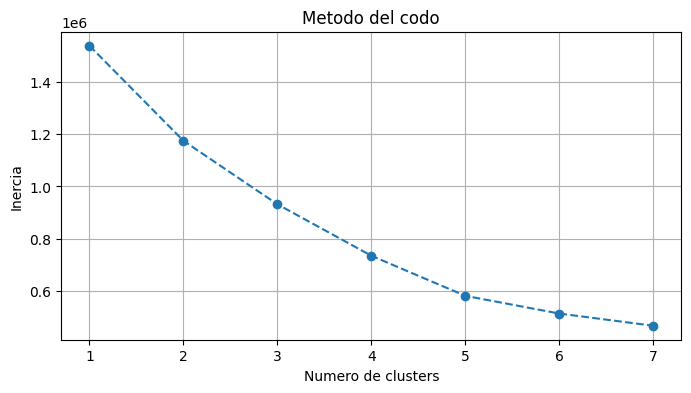

In [ ]:
# 2. Metodo de codo para visualizar los cluster
if df is not None:
    # Definimos las columnas que necesitamos para el clustering
    features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

    print("\nPreprocesando datos...")
    # Verificamos de las columnas
    missing_cols = [col for col in features if col not in df.columns]

    if not missing_cols:
        X = df[features].copy()

        # Limpieza
        X['DAYS_BIRTH'] = X['DAYS_BIRTH'] / -365  # Años positivos
        X['DAYS_EMPLOYED'] = X['DAYS_EMPLOYED'].replace(365243, np.nan) # Corregir error comun
        X['DAYS_EMPLOYED'] = X['DAYS_EMPLOYED'] / -365 # Años de antiguedad

        # Rellenar nulos
        X.fillna(X.median(), inplace=True)

        # Escalado
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # 3. Método del Codo
        inertia = []
        K_range = range(1, 8)

        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_scaled)
            inertia.append(kmeans.inertia_)

        # Gráfico del Codo
        plt.figure(figsize=(8, 4))
        plt.plot(K_range, inertia, marker='o', linestyle='--')
        plt.title('Metodo del codo')
        plt.xlabel('Numero de clusters')
        plt.ylabel('Inercia')
        plt.grid(True)
        plt.show()
else:
    print("No se pudo procesar porque la carga del archivo fallo.")


 Analisis detallado por grupo (5 CLUSTERS)

 CLUSTER 0
------------------------------
Cantidad de clientes: 72557 (23.6%)

 Estadisticas promedio:
                  Promedio del grupo
AMT_INCOME_TOTAL          232,369.45
AMT_CREDIT              1,125,171.87
AMT_ANNUITY                45,460.10
DAYS_BIRTH                     43.75
DAYS_EMPLOYED                   5.71
TARGET                          0.07

 Tasa de riesgo (Morosidad): 6.82%
   -> Este grupo es mas seguro que el promedio

 Ejemplo de 3 Clientes de este grupo:
   SK_ID_CURR  AMT_INCOME_TOTAL   AMT_CREDIT  AMT_ANNUITY  DAYS_BIRTH  \
1      100003        270,000.00 1,293,502.50    35,698.50       45.93   
6      100009        171,000.00 1,560,726.00    41,301.00       37.75   
7      100010        360,000.00 1,530,000.00    42,075.00       51.64   

   DAYS_EMPLOYED  TARGET  CLUSTER  
1           3.25       0        0  
6           8.58       0        0  
7           1.23       0        0  


 CLUSTER 1
---------------------

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


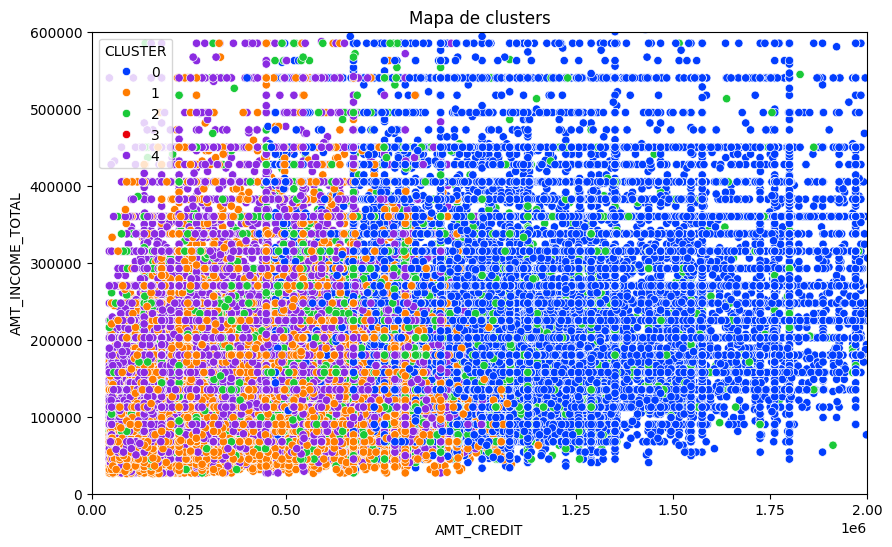

In [ ]:
# 4. Procesamiento y Clustering
if df is not None:
    features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

    # Prepararcion de datos
    X = df[features].copy()
    X['DAYS_BIRTH'] = X['DAYS_BIRTH'] / -365
    X['DAYS_EMPLOYED'] = X['DAYS_EMPLOYED'].replace(365243, np.nan) / -365
    X.fillna(X.median(), inplace=True)

    # Escalar
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # K-Means
    k_optim = 5
    kmeans = KMeans(n_clusters=k_optim, random_state=42, n_init=10)

    # Crear DataFrame de analisis
    cols_analysis = ['SK_ID_CURR'] + features
    if 'TARGET' in df.columns:
        cols_analysis.append('TARGET')

    df_analysis = df[cols_analysis].copy()

    # Ajustes visuales de columnas
    df_analysis['DAYS_BIRTH'] = df_analysis['DAYS_BIRTH'] / -365
    df_analysis['DAYS_EMPLOYED'] = df_analysis['DAYS_EMPLOYED'].replace(365243, np.nan) / -365

    # Asignar Cluster
    df_analysis['CLUSTER'] = kmeans.fit_predict(X_scaled)


    # 5. Informacion de los cluster
    print("\n" + "="*50)
    print(f" Analisis detallado por grupo ({k_optim} CLUSTERS)")
    print("="*50)

    # Iteracion por cada cluster
    for i in range(k_optim):
        grupo = df_analysis[df_analysis['CLUSTER'] == i]

        print(f"\n CLUSTER {i}")
        print("-" * 30)
        print(f"Cantidad de clientes: {len(grupo)} ({len(grupo)/len(df_analysis)*100:.1f}%)")

        # Estadisticas promedio del grupo
        cols_to_show = features + (['TARGET'] if 'TARGET' in df.columns else [])
        promedios = grupo[cols_to_show].mean().to_frame(name='Promedio del grupo')

        # Formateo para mejor lectura
        pd.options.display.float_format = '{:,.2f}'.format
        print("\n Estadisticas promedio:")
        print(promedios)

        # Interpretación rápida del riesgo (Si existe TARGET)
        if 'TARGET' in df.columns:
            riesgo = grupo['TARGET'].mean() * 100
            print(f"\n Tasa de riesgo (Morosidad): {riesgo:.2f}%")
            if riesgo > df_analysis['TARGET'].mean() * 100:
                print("   -> Este grupo es mas riesgoso que el promedio")
            else:
                print("   -> Este grupo es mas seguro que el promedio")

        print("\n Ejemplo de 3 Clientes de este grupo:")
        print(grupo.head(3))
        print("\n" + "="*50)

    # 6. Visualizacion General
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_analysis, x='AMT_CREDIT', y='AMT_INCOME_TOTAL', hue='CLUSTER', palette='bright')
    plt.title('Mapa de clusters')
    plt.ylim(0, 600000)
    plt.xlim(0, 2000000)
    plt.show()

else:
    print("Error: No se cargaron datos")